## Titanic - Machine Learning from Disaster 

### Part 1 Imports and Definitions


In [714]:
# import numpy, matplotlib, etc.
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


# sklearn imports
import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection


# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


# define the input and output folders
input_folder = "input/"
output_folder = "output/"

train_data_path = os.path.join(input_folder, "train.csv")
test_data_path = os.path.join(input_folder, "test.csv")

#### Load the traning data
- print all the contect of the input folder


In [715]:
for dirname, _, filenames in os.walk(input_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))


input/test.csv
input/train.csv


In [716]:
train_data = pd.read_csv(train_data_path)

test_data = pd.read_csv(test_data_path)


- remove the columns that are not needed


In [717]:
DROP_DATA = ["PassengerId", "Name", "Ticket"]

def remove_Unused_Columns(data):
    data = data.drop(DROP_DATA, axis=1)
    return data



def convet_gender_to_numric(data):
    # Define a dictionary to map 'female' to 0 and 'male' to 1
    sex_mapping = {'female': 0, 'male': 1}

    # Apply the mapping to the 'Sex' column
    data['Sex'] = data['Sex'].map(sex_mapping)


In [718]:
train_data = remove_Unused_Columns(train_data)

test_data = remove_Unused_Columns(test_data)


- print the head of the train.csv file

In [719]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


- Convert Men/Women to 1/0

In [720]:
convet_gender_to_numric(train_data)

convet_gender_to_numric(test_data)

### Part 2 Data Investigation


Get summary statistics for the training dataset show only the numerical columns


In [628]:
train_data.describe()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


Get the number of missing values in the training dataset


In [629]:
display(train_data.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

The dataset contains missing values in the following columns:

- Age: 177 missing values
- Cabin: 687 missing values (cabin has a lot of missing values)
- Embarked: 2 missing values


Get the data types of the columns in the training dataset


In [630]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


None

#### Display the features


In [631]:
def plot_and_calculate(df, column):
    # Plot the survival rate
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='Survived', data=df)
    plt.title(f'Survival Rate by {column}')
    plt.show()

    # Group by column and 'Survived', then get the size of each group
    grouped = df.groupby([column, 'Survived']).size()

    # Calculate the percentage of survivors
    percentage_survived = grouped.xs(1, level='Survived') / grouped.groupby(level=column).sum() * 100

    # Print the percentage of survivors
    print(f"Percentage of survivors for each {column}:")
    print(percentage_survived)

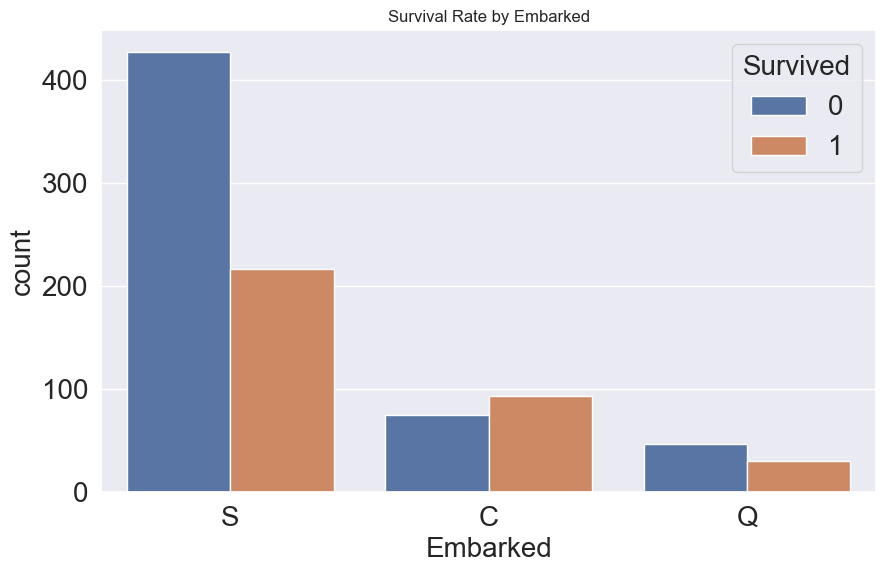

Percentage of survivors for each Embarked:
Embarked
C    55.357143
Q    38.961039
S    33.695652
dtype: float64


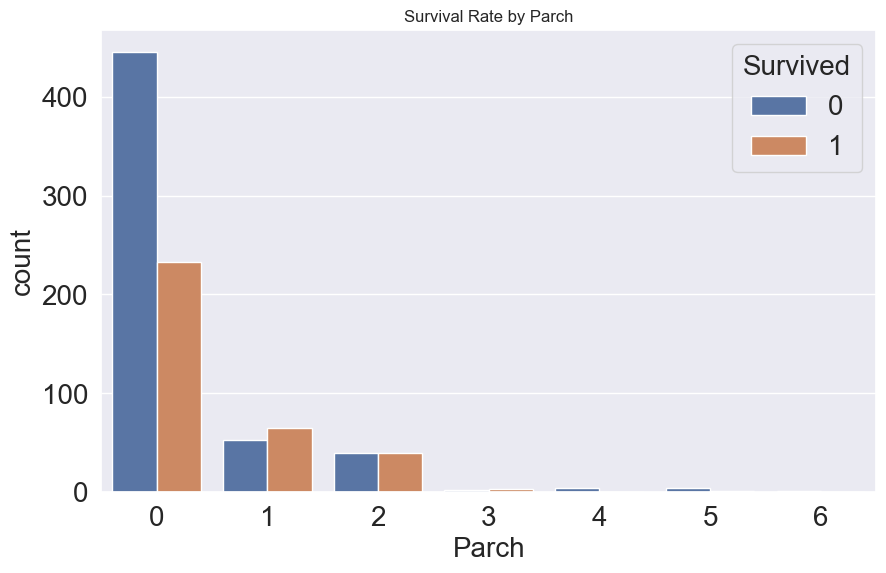

Percentage of survivors for each Parch:
Parch
0    34.365782
1    55.084746
2    50.000000
3    60.000000
4          NaN
5    20.000000
6          NaN
dtype: float64


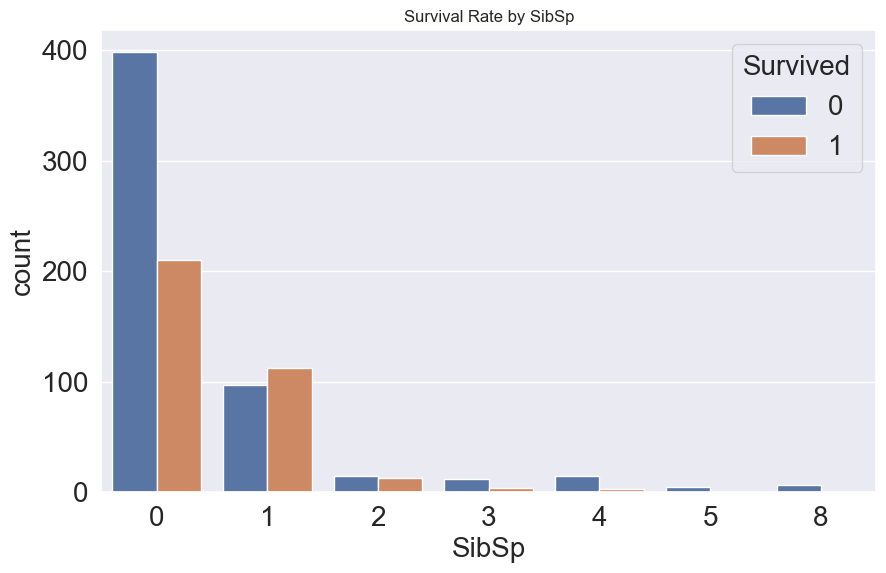

Percentage of survivors for each SibSp:
SibSp
0    34.539474
1    53.588517
2    46.428571
3    25.000000
4    16.666667
5          NaN
8          NaN
dtype: float64


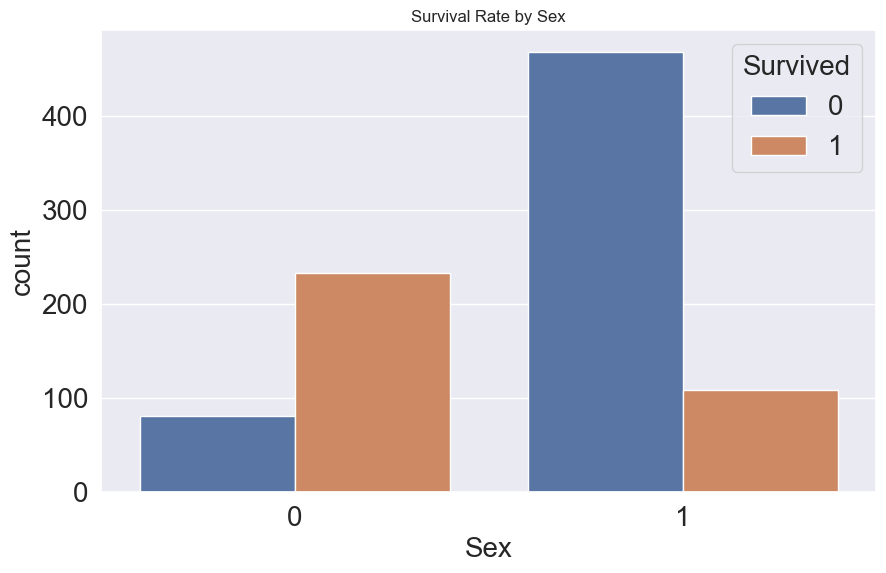

Percentage of survivors for each Sex:
Sex
0    74.203822
1    18.890815
dtype: float64


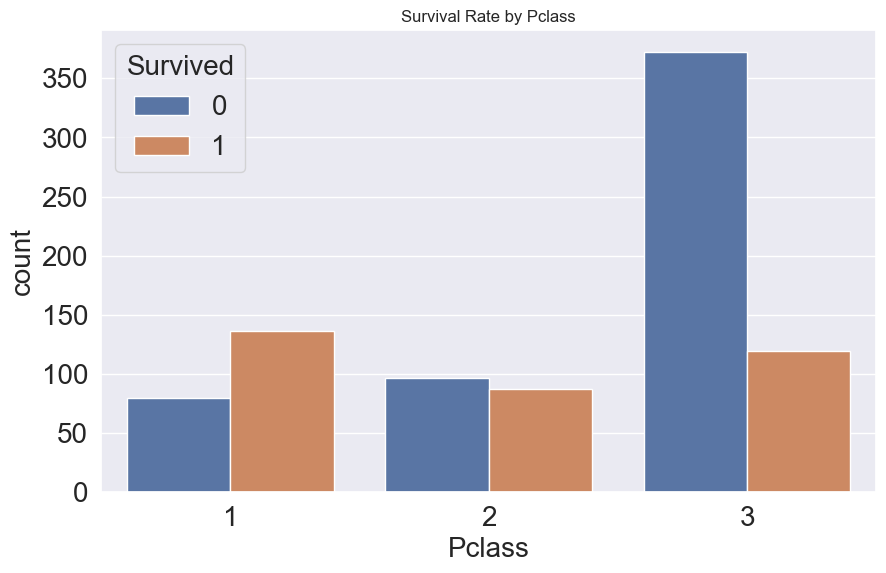

Percentage of survivors for each Pclass:
Pclass
1    62.962963
2    47.282609
3    24.236253
dtype: float64


In [632]:
plot_and_calculate(train_data, 'Embarked')
plot_and_calculate(train_data, 'Parch')
plot_and_calculate(train_data, 'SibSp')
plot_and_calculate(train_data, 'Sex')
plot_and_calculate(train_data, 'Pclass')


**Pairplot Visualizing Correlation**

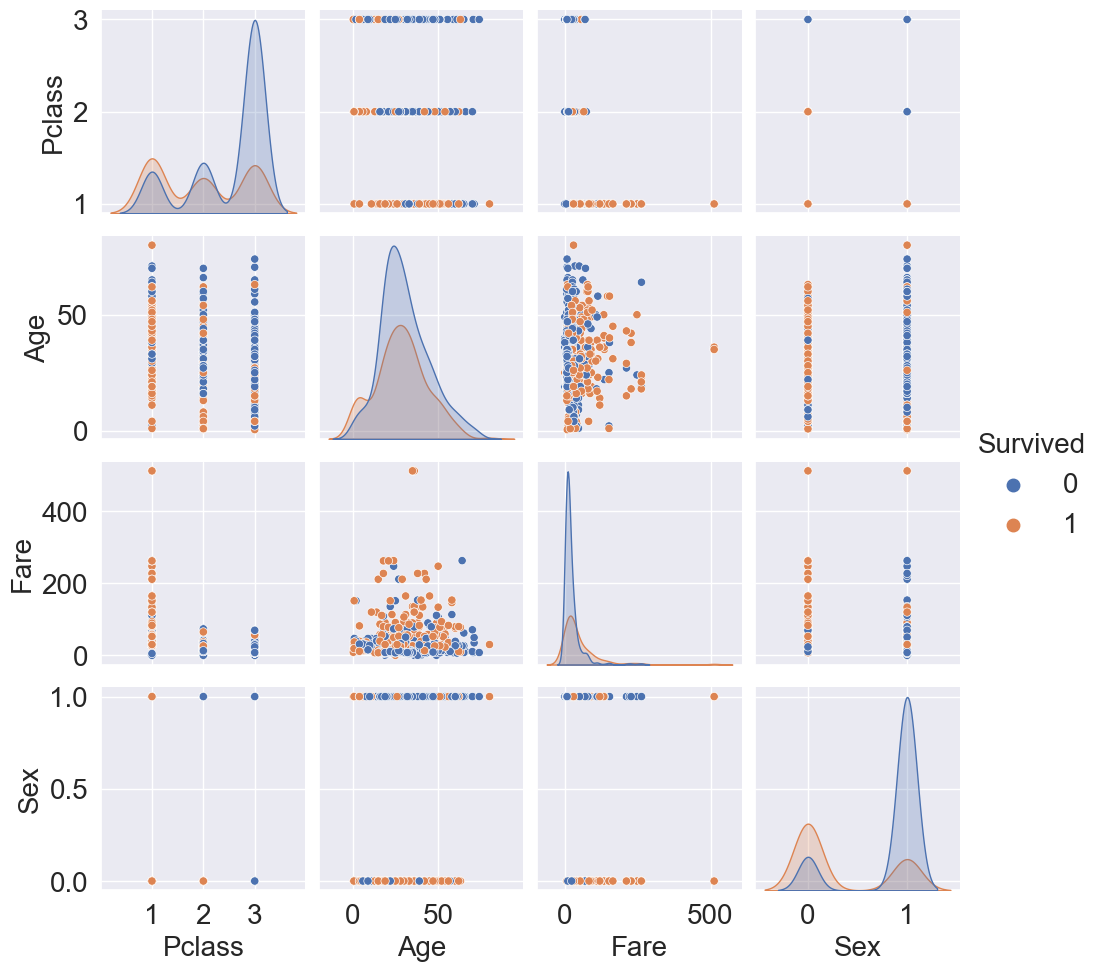

In [633]:
sns.pairplot(train_data[['Survived', 'Pclass', 'Age', 'Fare', 'Sex']], hue='Survived')
plt.show()

**Heatmap for correlation matrix**


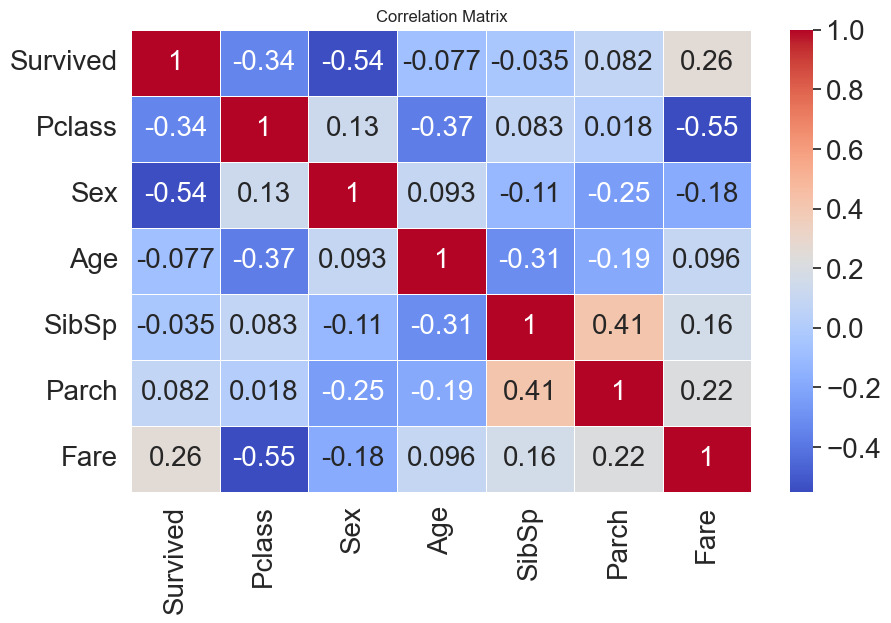

In [634]:
plt.figure(figsize=(10, 6))
corr_matrix = train_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Part 3 Data Cleaning and Preprocessing

Check for missing values in the train dataset


In [693]:
print(train_data.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


Fill Missing Values
- Fill missing Age values with the median
- Fill missing Embarked values with the most common port
- Drop the Cabin column due to too many missing value

In [694]:
from sklearn.impute import SimpleImputer


def fill_missing_values(data):
    data['Age'].fillna(data['Age'].mean(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data = handle_missing_values(data)
    return data

def drop_missing_values(data):
    data.drop(columns=['Cabin'], inplace=True)
    return data




def handle_missing_values(data):    
    # Impute numerical columns with mean
    imputer_num = SimpleImputer(strategy='mean')
    data[data.select_dtypes(include=['number']).columns] = imputer_num.fit_transform(data.select_dtypes(include=['number']))
    
    # Impute categorical columns with constant value 'missing'
    imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
    data[data.select_dtypes(exclude=['number']).columns] = imputer_cat.fit_transform(data.select_dtypes(exclude=['number']))
    
    return data



In [695]:
train_data = drop_missing_values(train_data)
train_data = fill_missing_values(train_data)

# test data
test_data = drop_missing_values(test_data)
test_data = fill_missing_values(test_data)


In [696]:
print(train_data.isnull().sum())

print(test_data.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


Convert Categorical Variables into Numerical Values
- Embarked use One-hot encode

In [697]:
def encode_categorical(data):
    # One-hot encode the categorical columns
    data = pd.get_dummies(data, columns=['Embarked'], drop_first=False)
    return data

In [698]:
train_data = encode_categorical(train_data)

test_data = encode_categorical(test_data)


In [699]:
print(train_data.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64


Standardize Numerical Features
- Standardize Age and Fare to have a mean of 0 and a standard deviation of 1.

In [700]:
from sklearn.preprocessing import StandardScaler

def scale_data(data):
    # Initialize the scaler
    scaler = StandardScaler()
    data[['Age', 'Fare']] = scaler.fit_transform(data[['Age', 'Fare']])
    return data

In [701]:
train_data = scale_data(train_data)

test_data = scale_data(test_data)


 Create New Features
 - Family Size
 - Is Alone

In [702]:
def create_features(data):
    # Create FamilySize feature
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

    # Create IsAlone feature
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    
    return data


def drop_features(data):
    data.drop(columns=['SibSp', 'Parch'], inplace=True)
    return data
    

In [703]:
# train data
train_data = create_features(train_data)
train_data = drop_features(train_data)
# test data
test_data = create_features(test_data)
test_data = drop_features(test_data)


Final Dataset

In [704]:
print(train_data.head())

print("\n\nmissing values in train data:\n")
print(train_data.isnull().sum())


   Survived  Pclass  Sex       Age      Fare  Embarked_C  Embarked_Q  \
0       0.0     3.0  1.0 -0.592481 -0.502445           0           0   
1       1.0     1.0  0.0  0.638789  0.786845           1           0   
2       1.0     3.0  0.0 -0.284663 -0.488854           0           0   
3       1.0     1.0  0.0  0.407926  0.420730           0           0   
4       0.0     3.0  1.0  0.407926 -0.486337           0           0   

   Embarked_S  FamilySize  IsAlone  
0           1         2.0        0  
1           0         2.0        0  
2           1         1.0        1  
3           1         2.0        0  
4           1         1.0        1  


missing values in train data:

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
FamilySize    0
IsAlone       0
dtype: int64


### Part 4 Feature Selection

Correlation matrix


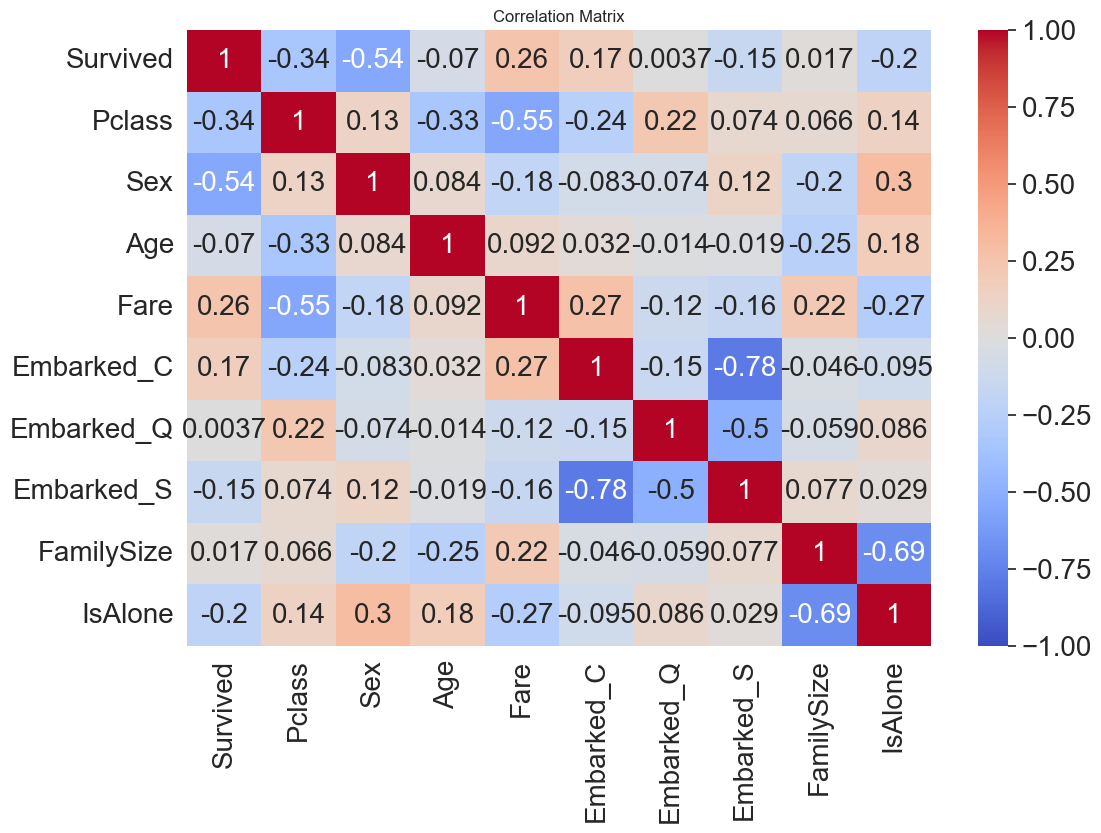

In [705]:
correlation_matrix = train_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


Feature Selection using Logistic Regression Coefficients

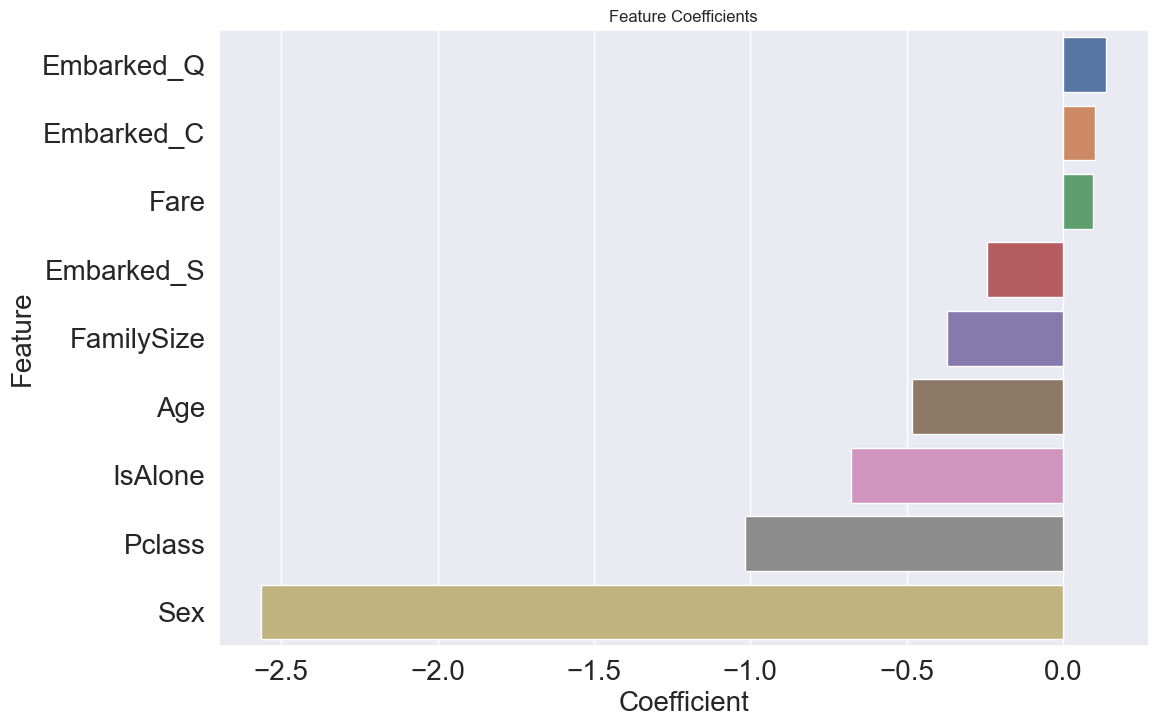

In [706]:
from sklearn.linear_model import LogisticRegression

# Select features and target
X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived']

# Encode categorical variables
X = pd.get_dummies(X)

# Initialize and fit Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X, y)

# Get coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# Plot coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Coefficients')
plt.show()


Remove low coefficient data TODO
- the features that are close to 0

In [707]:
print(train_data.head())

print("\n\nmissing values in train data:\n")
print(train_data.isnull().sum())


   Survived  Pclass  Sex       Age      Fare  Embarked_C  Embarked_Q  \
0       0.0     3.0  1.0 -0.592481 -0.502445           0           0   
1       1.0     1.0  0.0  0.638789  0.786845           1           0   
2       1.0     3.0  0.0 -0.284663 -0.488854           0           0   
3       1.0     1.0  0.0  0.407926  0.420730           0           0   
4       0.0     3.0  1.0  0.407926 -0.486337           0           0   

   Embarked_S  FamilySize  IsAlone  
0           1         2.0        0  
1           0         2.0        0  
2           1         1.0        1  
3           1         2.0        0  
4           1         1.0        1  


missing values in train data:

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
FamilySize    0
IsAlone       0
dtype: int64


### Part 5 Model Selection and Training

Split the data
- Train size = 0.8
- Validation size = 0.2

In [708]:
from sklearn.model_selection import train_test_split

# Select features and target
X = train_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'IsAlone']]
y = train_data['Survived']

# Split the data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the split datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_validation.shape, y_validation.shape)


Train set shape: (712, 9) (712,)
Validation set shape: (179, 9) (179,)


Model Selection and Training
- Logistic Regression
- MLP

In [709]:
# Initialize models
from sklearn.neural_network import MLPClassifier


log_reg = LogisticRegression(max_iter=1000, random_state=42)
mlp = MLPClassifier(max_iter=1000, random_state=42)  

# Train models
log_reg.fit(X_train, y_train)
mlp.fit(X_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)

Print scores of the models on the validation set


In [710]:
# Evaluate models
log_reg_score = log_reg.score(X_validation, y_validation)
mlp_score = mlp.score(X_validation, y_validation)

print("Logistic Regression Accuracy:", log_reg_score)
print("MLP Classifier Accuracy:", mlp_score)

Logistic Regression Accuracy: 0.8044692737430168
MLP Classifier Accuracy: 0.7988826815642458


### Part 6 Tests Model

create sumbission file for the test data

In [713]:
predictions = log_reg.predict(test_data)

output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
output.to_csv(output_folder + 'submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
